# Quantifying semisc similarity
## Chapter 031-Image-retrieval

### Author: Anders Kampenes

### Dimension reduction and visualization with PCA

In [ ]:
### Loading and preparing dataset

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pylab as plt 
from sklearn.datasets import load_digits 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Path hack.
import sys, os
sys.path.insert(0, os.path.abspath('..'))
from scripts.data_utils.plots import scatter, visualize_scatter_with_images, plot_similar_image 
from scripts.data_utils.generators import SimilarityImageGenerator, generate_directional_dataset, flatten_directional_data

#load  seimsic data
chapterName = "031-Image-retrieval-TSNE"
prevChapterName = "02-data_sequence_analysis"
input_folder = "/Users/anderskampenes/Documents/Dokumenter/NTNU/MASTER/code/notebooks/" + prevChapterName
output_folder = "/Users/anderskampenes/Documents/Dokumenter/NTNU/MASTER/code/notebooks/" + chapterName
data_cube = np.load("/Users/anderskampenes/Documents/Dokumenter/NTNU/MASTER/code/data/processed/f3_entire_int8.npy")

print("img shape", data_cube.shape)

directions, inline_samples, xline_samples, tline_samples,data, labels, num_samples, shape = generate_directional_dataset(data_cube)
#print("labels", labels["inline"], labels["xline"], labels["tline"])


/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

img shape (651, 951, 462)
651 951 462


In [13]:
### Dimension reduction and visualization with PCA

In [2]:
# flatten directions 
data = flatten_directional_data(data, num_samples)
print("flattten dirs", data["inline"].shape, data["xline"].shape, data["tline"].shape )


flattten dirs (651, 439362) (951, 300762) (462, 619101)


In [3]:
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold import TSNE
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)


# Random state we define this random state to use this value in TSNE which is a randmized algo.
RS = 25111993
T_SNE ={}
for dir in directions:
    filename = input_folder + "/T_SNE_" + dir + ".npy"
    if not os.path.exists(filename):
        print("did not find data.. creating new...")
        T_SNE[dir] = TSNE(random_state=RS).fit_transform(data[dir])
        # store the data 
        np.save(filename, T_SNE[dir])
    else:
        print("found data. loading it to memory")
        T_SNE[dir] = np.load(filename)




found data. loading it to memory
found data. loading it to memory
found data. loading it to memory


/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.manifold.t_sne module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.manifold. Anything that cannot be imported from sklearn.manifold is now part of the private API.
  warnings.warn(message, FutureWarning)


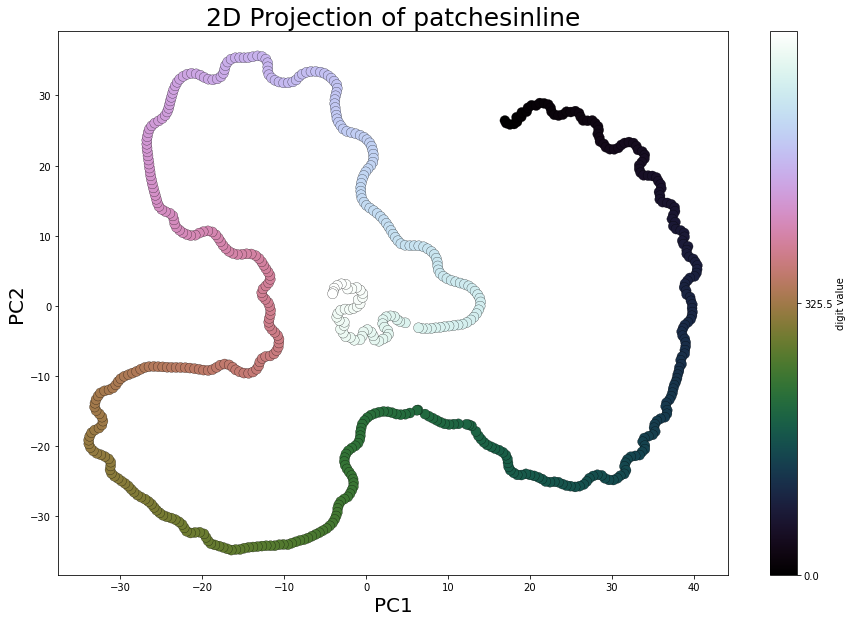

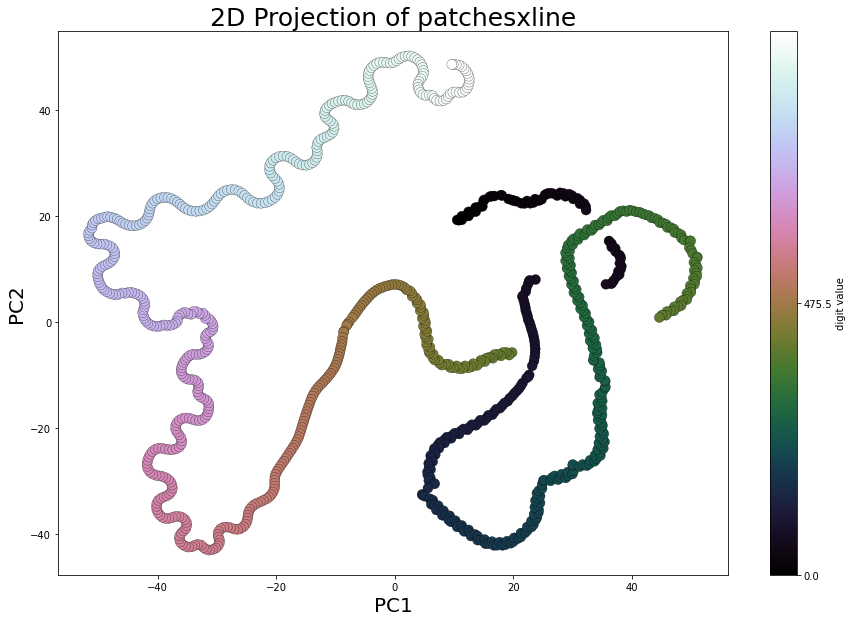

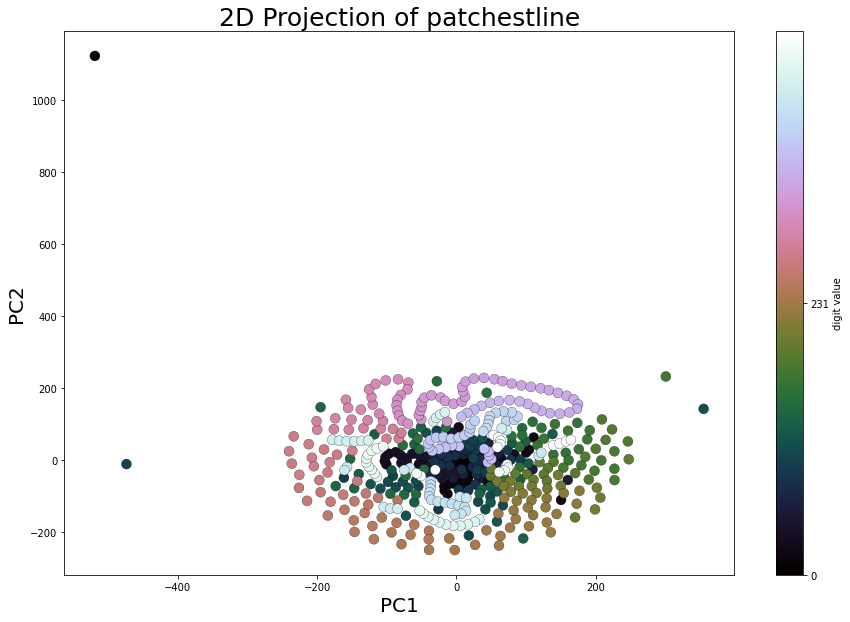

In [4]:
# scatter the different images with the original label     
for dir in directions:
    scatter(T_SNE[dir], labels[dir], num_samples[dir], dir, show_labels=False)

    

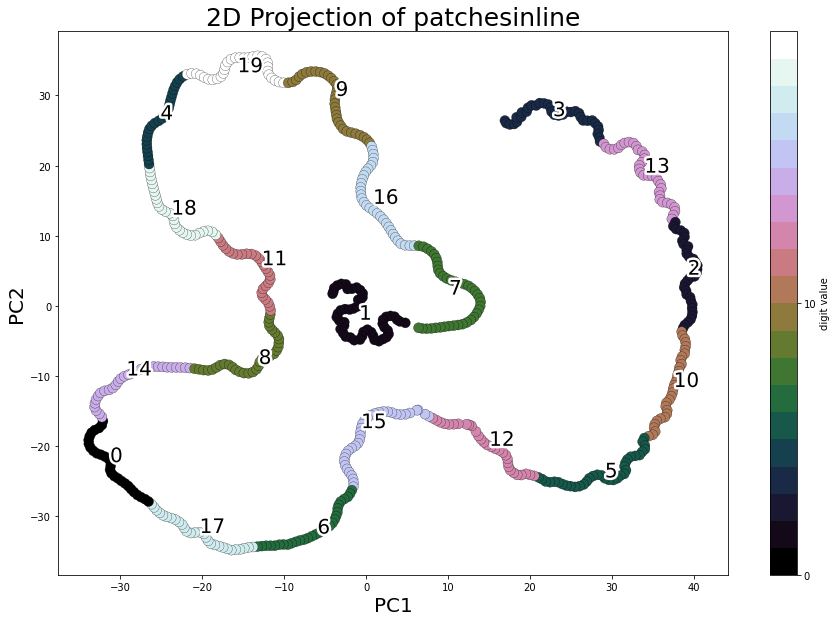

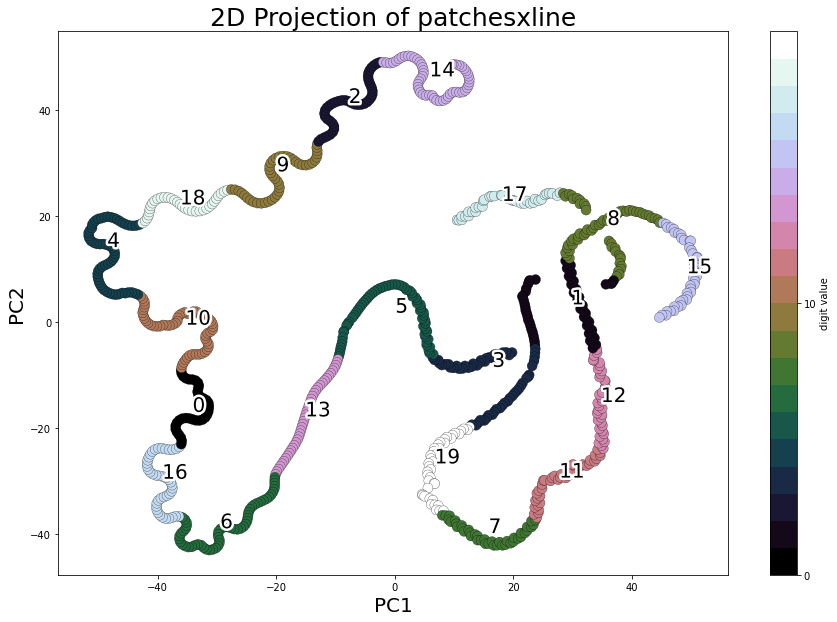

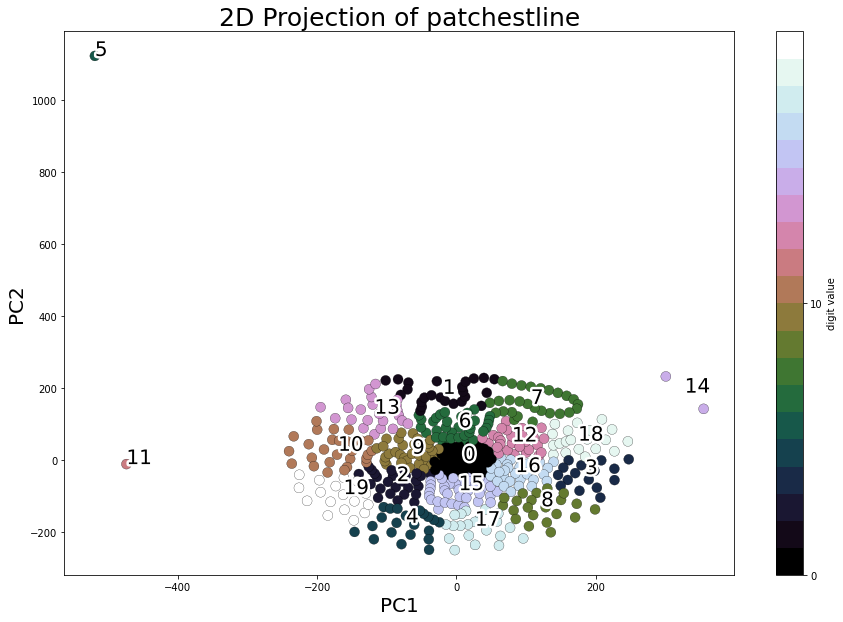

In [5]:
# perform k-means on each dir  to seperate into clusters?
from sklearn.cluster import KMeans

def perform_kmean(data,n_clusters):
    k_means = KMeans(n_clusters, random_state=0)
    k_means.fit(data)
    values = k_means.cluster_centers_.squeeze()
    labels_kmeans = k_means.labels_
    return k_means, values, labels_kmeans
n_clusters = 20

k_means= {}

for dir in directions:
    k_means[dir], values, labels_kmeans= perform_kmean(T_SNE[dir],n_clusters)

    # plot 
    scatter(T_SNE[dir], labels_kmeans, n_clusters, dir, output=output_folder +"/T_SNE_kmeans_"+dir+"_"+str(n_clusters)+".png", show_labels=True)

In [6]:
 ## next we need to calculate the median of each cluster 
centers = {}
#print(k_means[dir].cluster_centers_.squeeze(), len(labels_kmeans))
for dir in directions:
    centers[dir] = []
    for i in range(n_clusters):
        x, y = np.median(T_SNE[dir][k_means[dir].labels_ == i, :], axis=0)
        centers[dir].append((x, y, i))
        #print(dir,centers[dir][i])

In [7]:
# then we try to order the closest clusters to a given index 

def euclidean(coords):
    xx, yy,_ = ref
    x, y,_ = coords
    return ((x-xx)**2 + (y-yy)**2)**0.5

cluster_order = {}
for dir in directions:
    ref =centers[dir][0] # choose reference point to be cluster nr 0 
    print(ref)
    centers[dir].sort(key=euclidean)
    cluster_order[dir] = list(map(lambda x: x[-1], centers[dir]) )

    print(dir, cluster_order[dir])

(-31.254059, -22.302347, 0)
inline [0, 14, 17, 8, 6, 15, 11, 18, 1, 12, 7, 16, 4, 19, 9, 5, 10, 3, 2, 13]
(-34.122658, -16.980988, 0)
xline [0, 16, 10, 13, 6, 4, 5, 18, 19, 9, 3, 7, 11, 2, 17, 1, 12, 14, 8, 15]
(9.496228, -2.0157619, 0)
tline [0, 9, 16, 15, 12, 6, 2, 8, 18, 3, 10, 17, 13, 7, 1, 4, 19, 14, 11, 5]


REF [[30.655406951904297, 6.142796516418457, 1.0, 300.0]]
direction xline
treshold 50



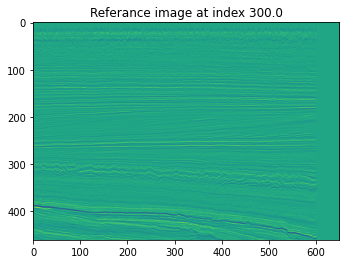

[458.0]

number left  950
plot_similar_image 0 758


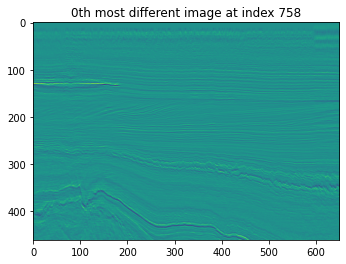

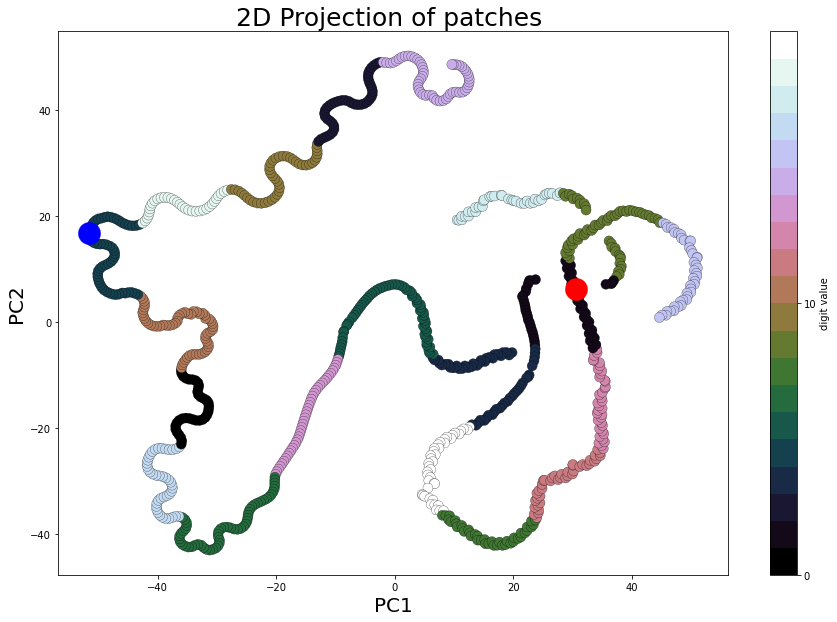

[272.0, 186.0]

number left  949
plot_similar_image 1 572


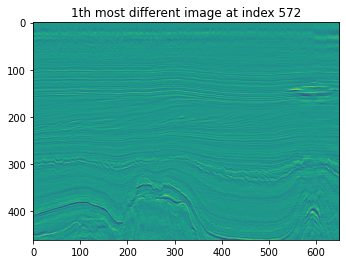

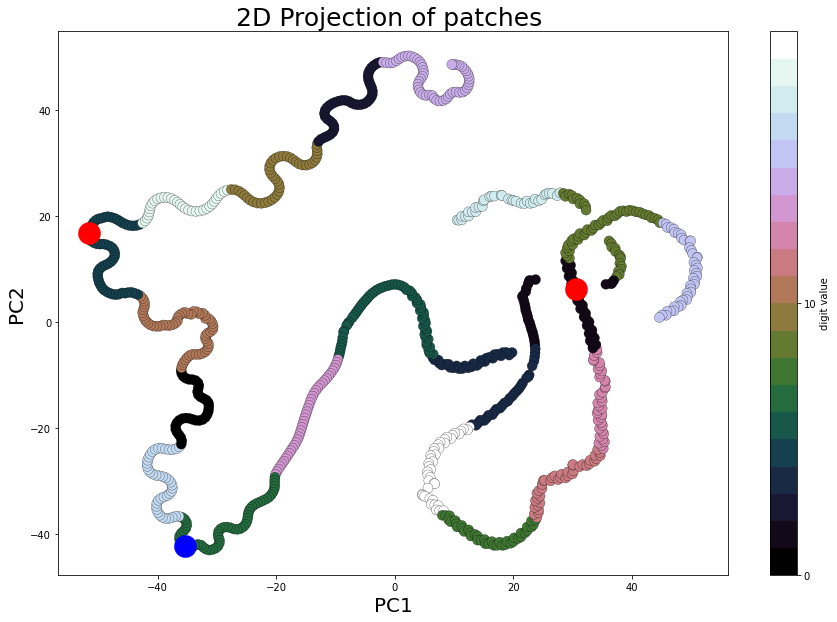

[67.0, 391.0, 205.0]

number left  948
plot_similar_image 2 367


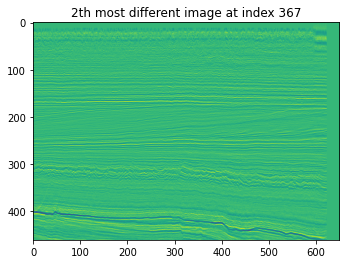

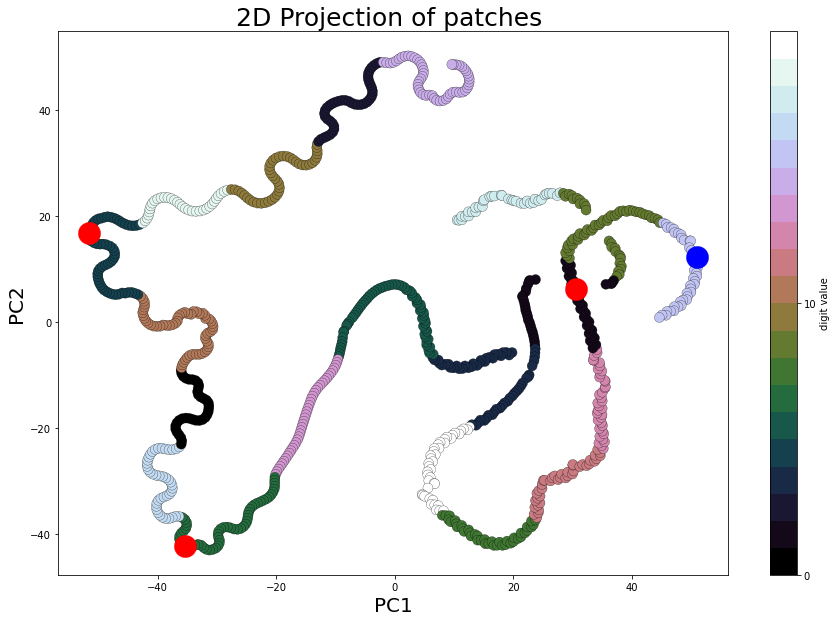

[606.0, 148.0, 334.0, 539.0]

number left  947
plot_similar_image 3 906


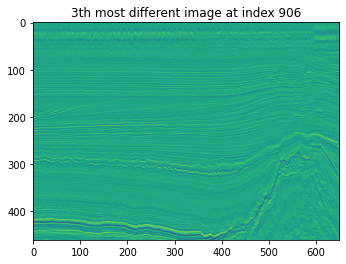

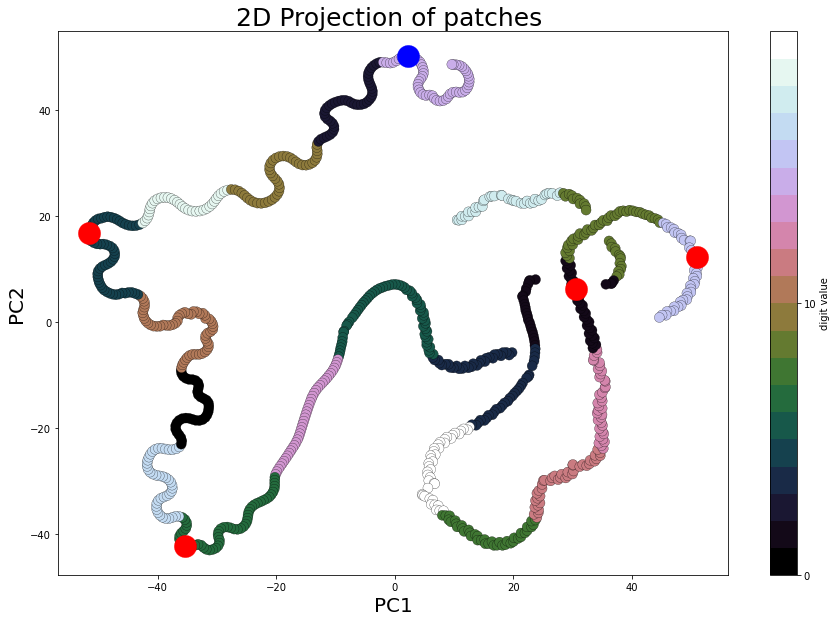

[113.0, 571.0, 385.0, 180.0, 719.0]

number left  946
plot_similar_image 4 187


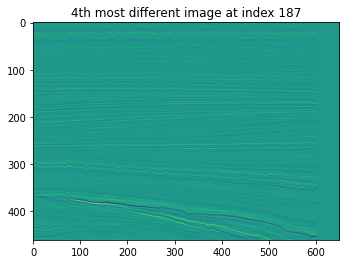

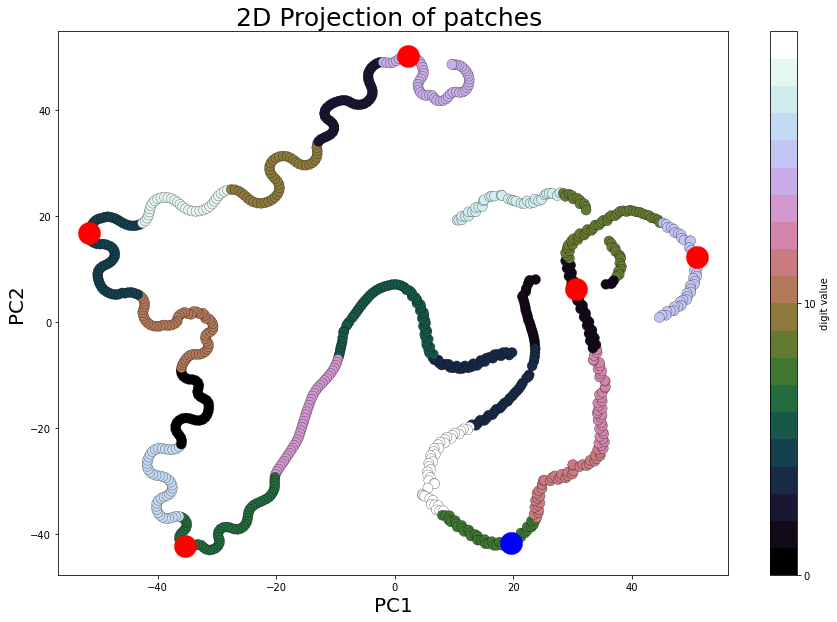

[462.0, 4.0, 190.0, 395.0, 144.0, 575.0]

number left  805
plot_similar_image 5 623


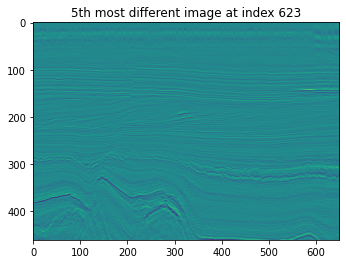

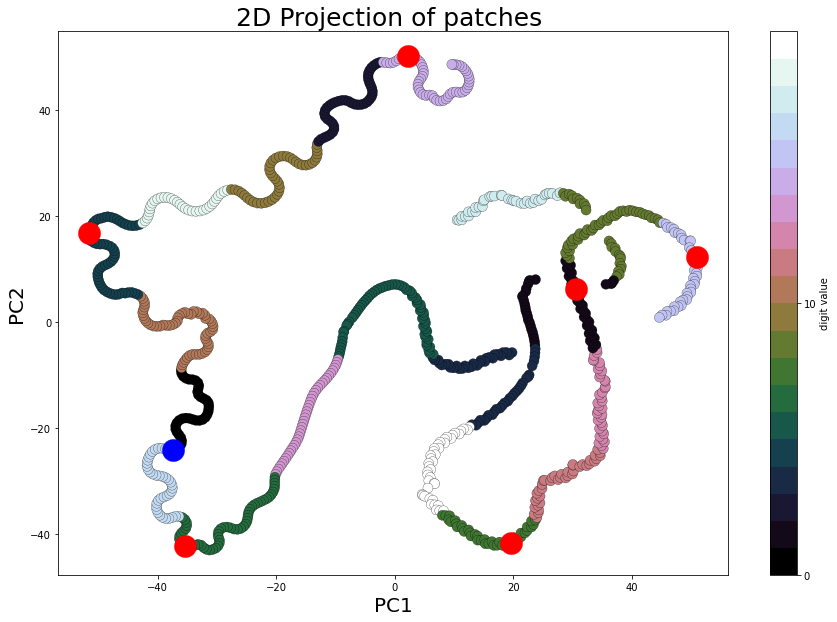

[647.0, 189.0, 375.0, 580.0, 41.0, 760.0, 324.0]

number left  654
plot_similar_image 6 240


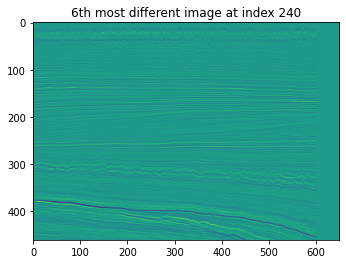

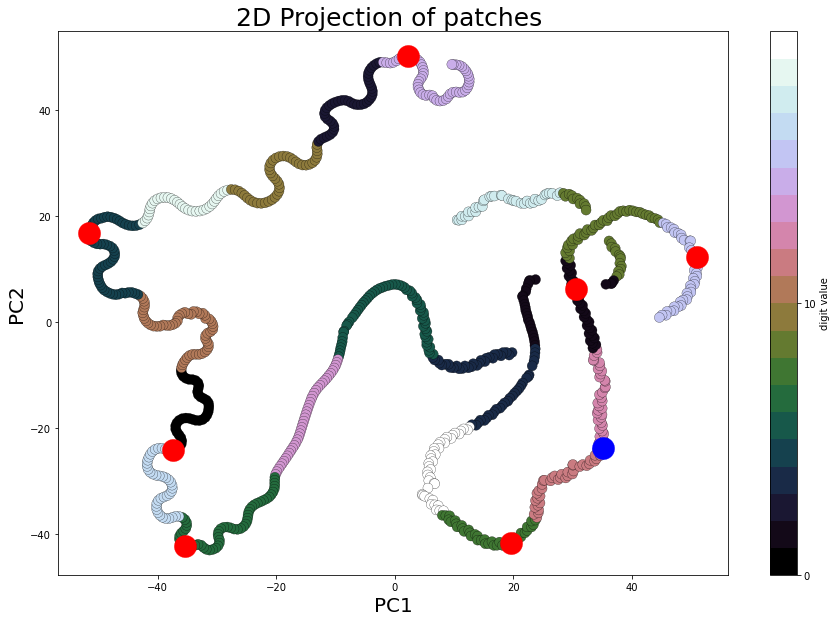

[495.0, 37.0, 223.0, 428.0, 111.0, 608.0, 172.0, 555.0]

number left  644
plot_similar_image 7 837


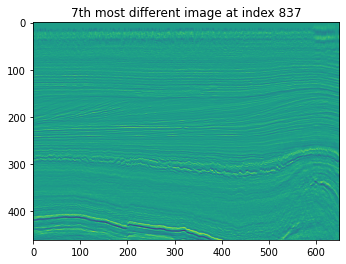

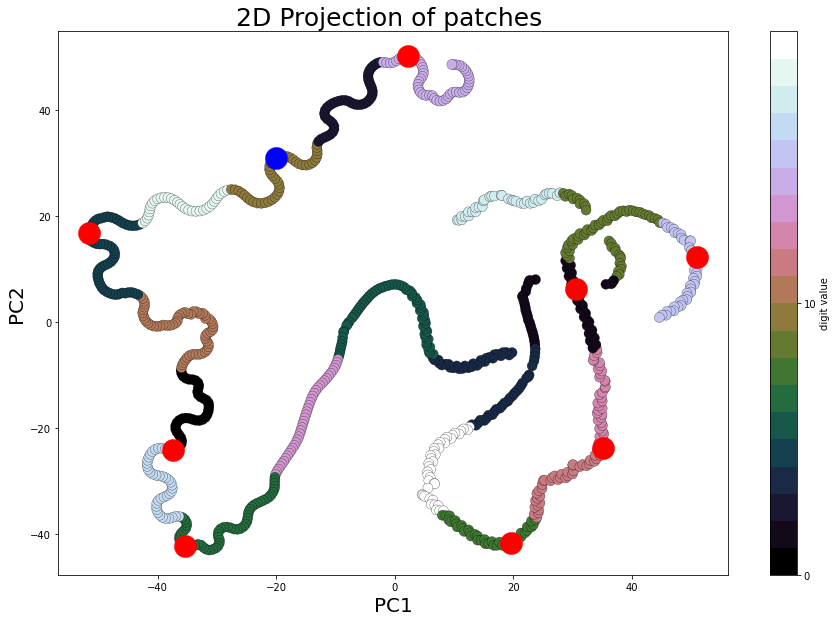

[249.0, 209.0, 23.0, 182.0, 357.0, 362.0, 74.0, 309.0, 288.0]

number left  593
plot_similar_image 8 707


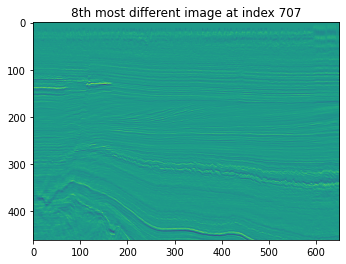

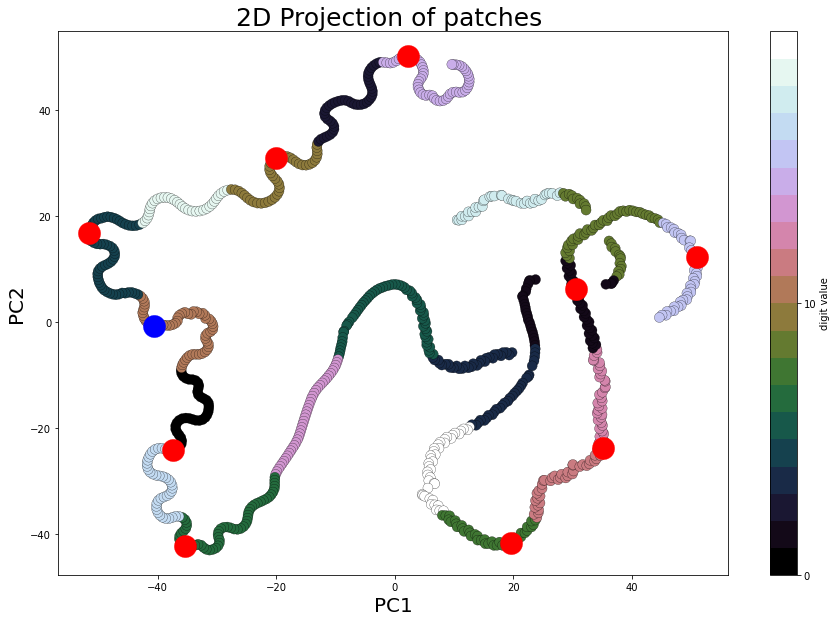

[33.0, 425.0, 239.0, 34.0, 573.0, 146.0, 290.0, 93.0, 504.0, 374.0]

number left  589
plot_similar_image 9 45


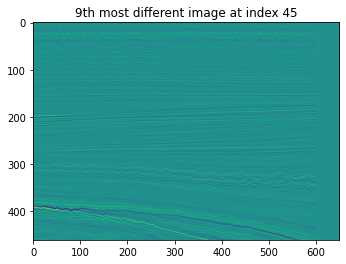

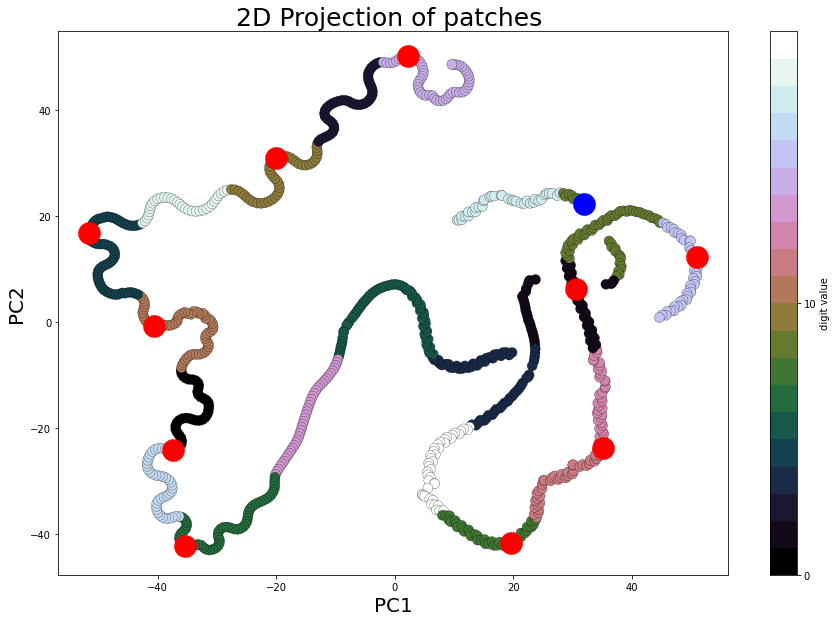

[128.0, 586.0, 400.0, 195.0, 734.0, 15.0, 451.0, 68.0, 665.0, 535.0, 127.0]

number left  358
plot_similar_image 10 521


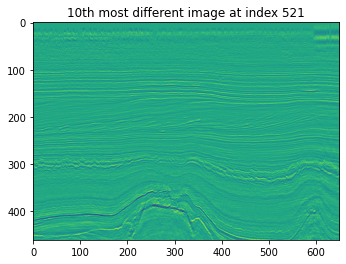

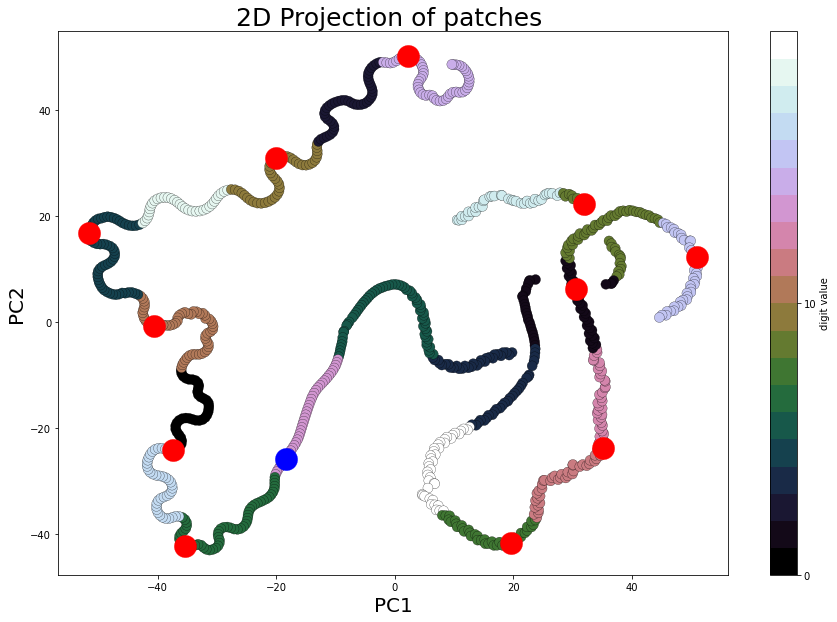

In [9]:
# now we see the indexes of the slices can still be prett close and there is nothing preventing the 10 next slices to be 10* apart.
# Ideally we would find the closest one, remove it from the leist and use it toghet with the previous ref to compute a joint distance
# distance to infer the next slice that is closes to these new points again. 
      
  
direction = "xline"
treshold = 50
# first we group togheter the T_SNE and the slice index labels
T_SNE_cluster_labels = k_means[direction].labels_
T_SNE_index_labels =  np.column_stack((T_SNE[direction], T_SNE_cluster_labels))
T_SNE_index_labels =  np.column_stack((T_SNE_index_labels, labels[direction])) 

ref = [T_SNE_index_labels[300].tolist()]
print("REF", ref)
print("direction", direction)
print("treshold", treshold)

#print(T_SNE[dir][k_means[dir].labels_ == 0, :])
ag = SimilarityImageGenerator(ref, direction, treshold, T_SNE_index_labels)
plt.imshow(data[direction][int(ref[0][-1])].reshape(shape[direction][0], shape[direction][1]).T)
plt.title(f'Referance image at index {ref[0][-1]}')
plt.show()
i = 0 
for img in ag:
    next_img = data[direction][int(img[-1])].reshape(shape[direction][0], shape[direction][1]).T
    ref_data = np.asarray(ref)
    ref_imgs = 0
    proj= T_SNE[direction]
    proj_labels = k_means[direction].labels_ 
    proj_num_samples = n_clusters
    plot_similar_image(i, int(img[-1]), next_img, ref_imgs, ref_data, proj, proj_labels, proj_num_samples)
    i= i+1
    if i > 10:
        break

    